Nama : Akmal Syarifuddin

Dataset : Movie

Link download dataset : https://www.kaggle.com/lokkagle/movie-genre-data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk as nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
class ModelCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.9):
      print("Expected accuracy have been achieved")
      self.model.stop_training = True
cb = ModelCallbacks()

In [4]:
data = pd.read_csv('/content/drive/My Drive/kaggle_movie_train.csv', sep = ',')
data.tail()

,id,text,genre
22574,28161,n in the world to decide what I'm going to do ...,drama
22575,28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,28165,....with marked skill and dexterity . LANA wry...,action
22578,28166,"rd walks off down the hallway, leaving his pos...",comedy


In [5]:
data['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

In [6]:
data = data.drop(columns=['id'])

In [7]:
data.head()

,text,genre
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,"t, summa cum laude and all. And I'm about to l...",comedy
2,"up Come, I have a surprise.... She takes him ...",drama
3,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,"nd dismounts, just as the other children reach...",drama


In [8]:
data = data[~data['genre'].isin(['sci-fi','horror','other','adventure','romance'])]
data['genre'].value_counts()

drama       8873
thriller    6824
comedy      2941
action      2392
Name: genre, dtype: int64

In [9]:
genre = pd.get_dummies(data['genre'])
new_data = pd.concat([data, genre], axis=1)
new_data = new_data.drop(columns='genre')
new_data

,text,action,comedy,drama,thriller
0,"eady dead, maybe even wishing he was. INT. 2ND...",0,0,0,1
1,"t, summa cum laude and all. And I'm about to l...",0,1,0,0
2,"up Come, I have a surprise.... She takes him ...",0,0,1,0
3,ded by the two detectives. INT. JEFF'S APARTME...,0,0,0,1
4,"nd dismounts, just as the other children reach...",0,0,1,0
...,...,...,...,...,...
22574,n in the world to decide what I'm going to do ...,0,0,1,0
22575,shards. BOJO LAZ! Laz pushes Deke back through...,0,0,1,0
22576,"OTTIE You've got a thing about Ernie's, haven'...",0,0,0,1
22577,....with marked skill and dexterity . LANA wry...,1,0,0,0


In [10]:
new_data.columns

Index(['text', 'action', 'comedy', 'drama', 'thriller'], dtype='object')

In [11]:
about_film = new_data['text'].astype(str)
genre_film = new_data[[
       'action', 'comedy', 'drama', 'thriller']].values

In [12]:
train_about, test_about, train_genre, test_genre = train_test_split(about_film, genre_film, test_size=0.2)

In [17]:
# Remove stopwords
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
porter_stemmer = nltk.PorterStemmer()

# Tokenize, remove stopwords, and apply stemming
train_about_tokens = train_about.apply(lambda x: word_tokenize(x))
test_about_tokens = test_about.apply(lambda x: word_tokenize(x))

train_about_tokens = train_about_tokens.apply(lambda x: [porter_stemmer.stem(word.lower()) for word in x if word.lower() not in stop_words])
test_about_tokens = test_about_tokens.apply(lambda x: [porter_stemmer.stem(word.lower()) for word in x if word.lower() not in stop_words])

# Convert tokenized text back to string
train_about = train_about_tokens.apply(lambda x: ' '.join(x))
test_about = test_about_tokens.apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=5000, oov_token='*')

tokenizer.fit_on_texts(train_about)
tokenizer.fit_on_texts(test_about)

train_sequence = tokenizer.texts_to_sequences(train_about)
test_sequence = tokenizer.texts_to_sequences(test_about)

train_padded = pad_sequences(train_sequence)
test_padded = pad_sequences(test_sequence)

In [19]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 109572 (428.02 KB)
Trainable params: 109572 (428.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model_history = model.fit(
    train_padded,
    train_genre,
    epochs=50,
    validation_data=(test_padded, test_genre),
    verbose=2,
    batch_size=128,
    callbacks=[cb]
  )

Epoch 1/50
132/132 - 33s - loss: 1.1988 - accuracy: 0.4293 - val_loss: 0.9226 - val_accuracy: 0.5114 - 33s/epoch - 250ms/step
Epoch 2/50
132/132 - 30s - loss: 0.8268 - accuracy: 0.5755 - val_loss: 0.8828 - val_accuracy: 0.6046 - 30s/epoch - 224ms/step
Epoch 3/50
132/132 - 30s - loss: 0.5991 - accuracy: 0.7270 - val_loss: 0.5587 - val_accuracy: 0.7646 - 30s/epoch - 225ms/step
Epoch 4/50
132/132 - 32s - loss: 0.3785 - accuracy: 0.8394 - val_loss: 0.4454 - val_accuracy: 0.8476 - 32s/epoch - 244ms/step
Epoch 5/50
132/132 - 29s - loss: 0.2568 - accuracy: 0.9108 - val_loss: 0.5014 - val_accuracy: 0.8248 - 29s/epoch - 221ms/step
Epoch 6/50
132/132 - 29s - loss: 0.1943 - accuracy: 0.9370 - val_loss: 0.5160 - val_accuracy: 0.8547 - 29s/epoch - 221ms/step
Epoch 7/50
132/132 - 29s - loss: 0.1313 - accuracy: 0.9585 - val_loss: 0.5272 - val_accuracy: 0.8602 - 29s/epoch - 222ms/step
Epoch 8/50
132/132 - 30s - loss: 0.1054 - accuracy: 0.9662 - val_loss: 0.5568 - val_accuracy: 0.8666 - 30s/epoch - 226

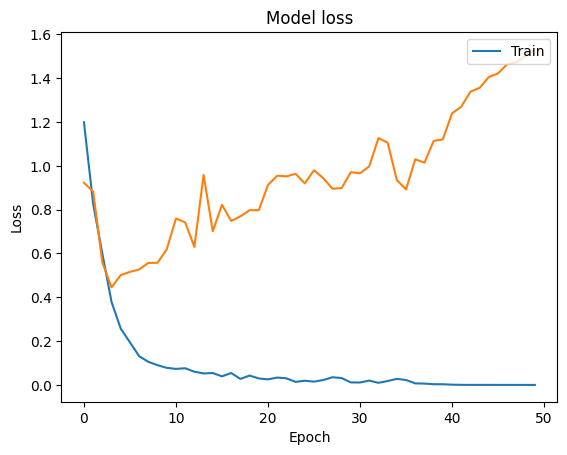

In [22]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

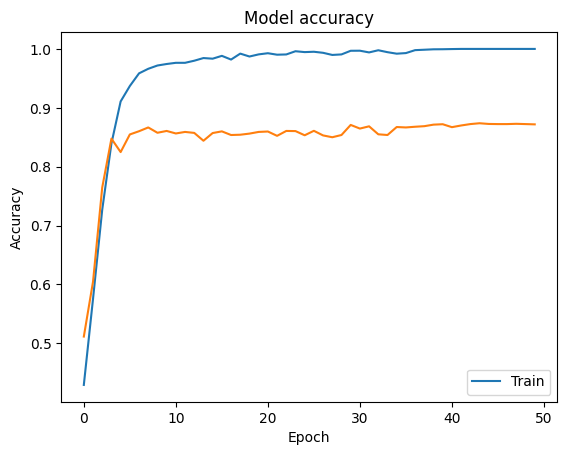

In [23]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()